In [1]:
!pip install deep-phonemizer

In [2]:
import torch
import torchaudio

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [3]:
import IPython
import matplotlib.pyplot as plt

In [18]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello, my name is park joe hyeon"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 6, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 27, 12, 29, 22, 11, 21, 26, 16, 11, 19, 36, 16, 26, 25]


In [19]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello, my name is park joe hyeon"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26,  6, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11,
         27, 12, 29, 22, 11, 21, 26, 16, 11, 19, 36, 16, 26, 25]])
tensor([32], dtype=torch.int32)


In [20]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ',', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'a', 'r', 'k', ' ', 'j', 'o', 'e', ' ', 'h', 'y', 'e', 'o', 'n']


In [22]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello, my name is park joe hyeon"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 20, 65, 69,  6, 11, 66, 32, 11, 67, 48, 66, 11, 55, 94, 11, 77, 12,
         78, 64, 11, 63, 69, 11, 54, 32, 20, 67]])
tensor([28], dtype=torch.int32)


In [23]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ',', ' ', 'M', 'AY', ' ', 'N', 'EY', 'M', ' ', 'IH', 'Z', ' ', 'P', 'AA', 'R', 'K', ' ', 'JH', 'OW', ' ', 'HH', 'AY', 'AH', 'N']


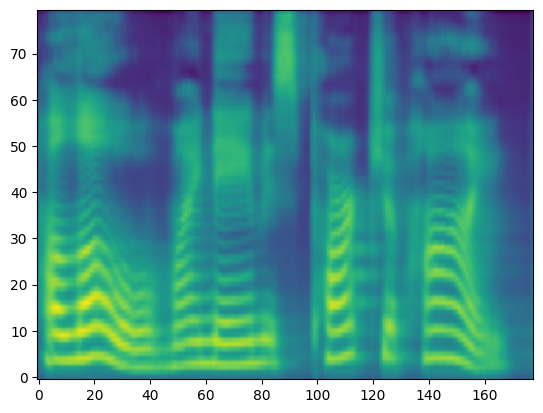

In [50]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello, my name is park joe hyun"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 201])
torch.Size([80, 202])
torch.Size([80, 179])


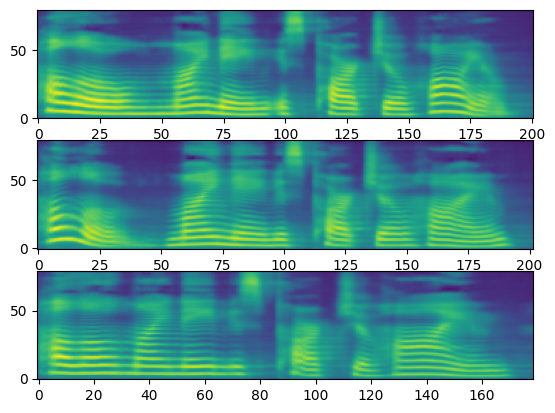

In [51]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

In [52]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello, my name is park joe hyeon"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

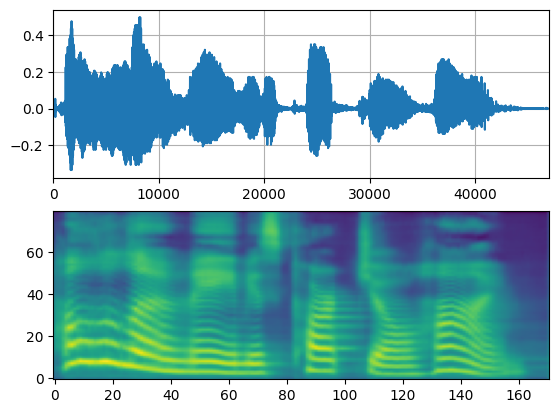

In [53]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

In [54]:
device = 'cpu'  # MPS 대신 CPU 사용

bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

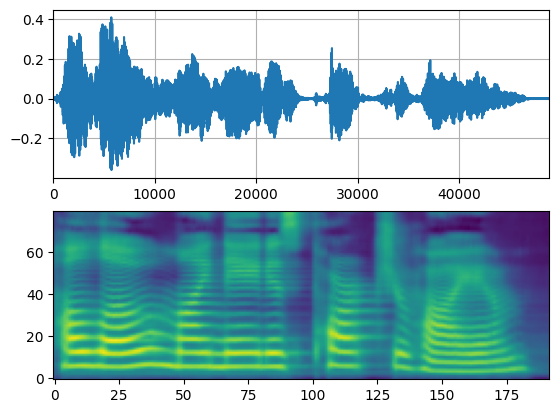

In [55]:
plot(waveforms, spec, vocoder.sample_rate)

In [56]:
device = 'mps'

In [58]:
# MPS 디바이스에서 지원되지 않는 연산을 CPU로 폴백하도록 환경 변수 설정
import os
import torch

# 환경 변수를 코드 최상단에 설정하고, PyTorch import 전에 설정되도록 함
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# device 변수가 정의되지 않은 것 같아 추가
# MPS 대신 CPU를 사용하도록 명시적으로 설정
device = torch.device('cpu')  # 문제가 계속되면 명시적으로 CPU 사용

# 나머지 코드는 동일하게 유지
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

Using cache found in /Users/parkjoehyun/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


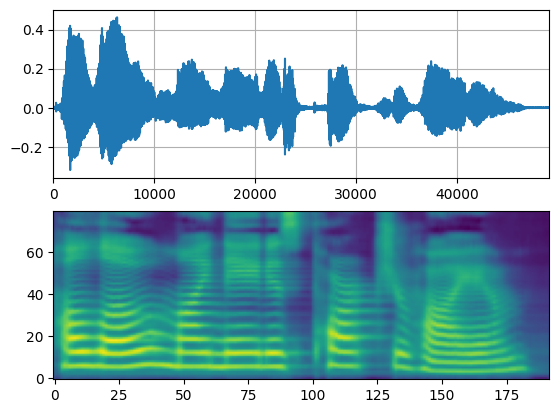

In [59]:
plot(waveforms, spec, 22050)